<a href="https://colab.research.google.com/github/yazuyuichiro/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow-2nd-Edition/blob/master/17ch/17.3.5-17.7/%E5%AE%9F%E8%B7%B5%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%9217.3.5~17.7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [49]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## 17.3.5 重みの均等化

In [50]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [51]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [52]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3265 - rounded_accuracy: 0.8961 - val_loss: 0.3061 - val_rounded_accuracy: 0.9116
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2982 - rounded_accuracy: 0.9213 - val_loss: 0.2960 - val_rounded_accuracy: 0.9251
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2921 - rounded_accuracy: 0.9272 - val_loss: 0.2953 - val_rounded_accuracy: 0.9194
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2888 - rounded_accuracy: 0.9303 - val_loss: 0.2884 - val_rounded_accuracy: 0.9334
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2867 - rounded_accuracy: 0.9323 - val_loss: 0.2884 - val_rounded_accuracy: 0.9297
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2853 - rounded_accuracy: 0.9337 - val_loss: 0.2861 - val_rounded_accuracy: 0.9349
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 21ms/step


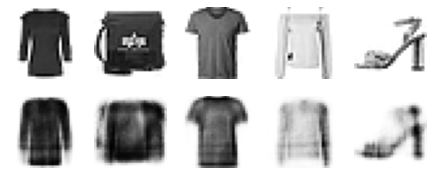

In [57]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(tied_ae)
plt.show()

## 17.4 畳み込みオートエンコーダ

In [58]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 45s 25ms/step - loss: 0.3000 - rounded_accuracy: 0.9199 - val_loss: 0.2823 - val_rounded_accuracy: 0.9387
Epoch 2/5
1719/1719 [==============================] - 44s 26ms/step - loss: 0.2756 - rounded_accuracy: 0.9412 - val_loss: 0.2726 - val_rounded_accuracy: 0.9463
Epoch 3/5
1719/1719 [==============================] - 43s 25ms/step - loss: 0.2709 - rounded_accuracy: 0.9461 - val_loss: 0.2693 - val_rounded_accuracy: 0.9499
Epoch 4/5
1719/1719 [==============================] - 44s 25ms/step - loss: 0.2684 - rounded_accuracy: 0.9487 - val_loss: 0.2680 - val_rounded_accuracy: 0.9506
Epoch 5/5
1719/1719 [==============================] - 44s 25ms/step - loss: 0.2666 - rounded_accuracy: 0.9506 - val_loss: 0.2672 - val_rounded_accuracy: 0.9510


Qiita - KerasのConv2DTransposeの動作について  
https://qiita.com/takurooo/items/9a9f387390f5fcf5a516

## 17.5 再帰型オートエンコーダ

In [73]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]), # kerasでLSTMを使う際はinput.shapeは(batch_size, timesteps, input_dim)
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]), # (None, 30) -> (None, 28, 30)
    keras.layers.LSTM(100, return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid")) # 各タイムステップに対して引数を適用
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [65]:
recurrent_encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 100)           51600     
                                                                 
 lstm_1 (LSTM)               (None, 30)                15720     
                                                                 
Total params: 67,320
Trainable params: 67,320
Non-trainable params: 0
_________________________________________________________________


In [64]:
recurrent_decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVector  (None, 28, 30)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 28, 100)           52400     
                                                                 
 time_distributed (TimeDistr  (None, 28, 28)           2828      
 ibuted)                                                         
                                                                 
Total params: 55,228
Trainable params: 55,228
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 [==============================] - 84s 47ms/step - loss: 0.5075 - rounded_accuracy: 0.7652 - val_loss: 0.4452 - val_rounded_accuracy: 0.8131
Epoch 2/10
1719/1719 [==============================] - 80s 46ms/step - loss: 0.3993 - rounded_accuracy: 0.8440 - val_loss: 0.3767 - val_rounded_accuracy: 0.8590
Epoch 3/10
1719/1719 [==============================] - 80s 47ms/step - loss: 0.3629 - rounded_accuracy: 0.8726 - val_loss: 0.3561 - val_rounded_accuracy: 0.8796
Epoch 4/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3483 - rounded_accuracy: 0.8834 - val_loss: 0.3432 - val_rounded_accuracy: 0.8899
Epoch 5/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.3384 - rounded_accuracy: 0.8901 - val_loss: 0.3373 - val_rounded_accuracy: 0.8903
Epoch 6/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3317 - rounded_accuracy: 0.8946 - val_loss: 0.3288 - val_rounded_accuracy: 0.8989
Epoch 7/10
1719/1719 [======

## 17.6 ノイズを除去するオートエンコーダ

In [74]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2), 
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3515 - rounded_accuracy: 0.8760 - val_loss: 0.3193 - val_rounded_accuracy: 0.9067
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3133 - rounded_accuracy: 0.9087 - val_loss: 0.3089 - val_rounded_accuracy: 0.9155
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3060 - rounded_accuracy: 0.9151 - val_loss: 0.3029 - val_rounded_accuracy: 0.9183
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3018 - rounded_accuracy: 0.9189 - val_loss: 0.2993 - val_rounded_accuracy: 0.9229
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2989 - rounded_accuracy: 0.9214 - val_loss: 0.2968 - val_rounded_accuracy: 0.9245
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2969 - rounded_accuracy: 0.9231 - val_loss: 0.2950 - val_rounded_accuracy: 0.9271
Epoch 7/10
1719/1719 [================

1/1 [==============================] - 0s 210ms/step


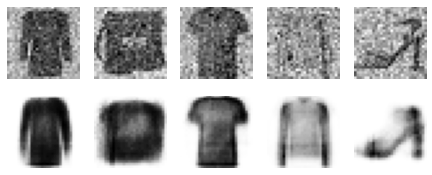

In [75]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

## 17.7 スパース・オートエンコーダ

In [78]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4302 - rounded_accuracy: 0.8168 - val_loss: 0.3842 - val_rounded_accuracy: 0.8509
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3699 - rounded_accuracy: 0.8685 - val_loss: 0.3653 - val_rounded_accuracy: 0.8730
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3563 - rounded_accuracy: 0.8787 - val_loss: 0.3519 - val_rounded_accuracy: 0.8865
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3437 - rounded_accuracy: 0.8878 - val_loss: 0.3416 - val_rounded_accuracy: 0.8912
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3371 - rounded_accuracy: 0.8922 - val_loss: 0.3365 - val_rounded_accuracy: 0.8929
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3319 - rounded_accuracy: 0.8965 - val_loss: 0.3314 - val_rounded_accuracy: 0.8972
Epoch 7/10
1719/1719 [===============

1/1 [==============================] - 0s 96ms/step


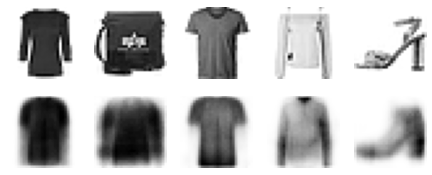

In [79]:
show_reconstructions(sparse_l1_ae)

In [85]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [86]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 17s 7ms/step - loss: 0.4150 - rounded_accuracy: 0.8125 - val_loss: 0.3707 - val_rounded_accuracy: 0.8601
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3534 - rounded_accuracy: 0.8773 - val_loss: 0.3443 - val_rounded_accuracy: 0.8860
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3349 - rounded_accuracy: 0.8910 - val_loss: 0.3315 - val_rounded_accuracy: 0.8951
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3237 - rounded_accuracy: 0.9006 - val_loss: 0.3220 - val_rounded_accuracy: 0.9035
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3174 - rounded_accuracy: 0.9058 - val_loss: 0.3176 - val_rounded_accuracy: 0.9074
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3137 - rounded_accuracy: 0.9090 - val_loss: 0.3142 - val_rounded_accuracy: 0.9097
Epoch 7/10
1719/1719 [=============